In [3]:
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer

In [ ]:
df = pd.read_parquet('../data/tom/exploretom/train.parquet')
dft = pd.read_parquet('../data/tom/exploretom/test.parquet')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [62]:
len(dft)

2662

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10647 entries, 0 to 10646
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   story_structure                          10647 non-null  object 
 1   infilled_story                           10647 non-null  object 
 2   question                                 10647 non-null  object 
 3   expected_answer                          10647 non-null  object 
 4   qprop=params                             10647 non-null  object 
 5   qprop=nth_order                          10647 non-null  int64  
 6   qprop=non_unique_mental_state            10647 non-null  bool   
 7   sprop=is_false_belief_story_1st          10647 non-null  bool   
 8   sprop=is_false_belief_story_1st_and_2nd  10647 non-null  bool   
 9   sprop=story_accuracy_1st_raw             10647 non-null  float64
 10  sprop=story_accuracy_1st_infilled        10647

<Axes: xlabel='sprop=story_accuracy_1st_infilled', ylabel='Count'>

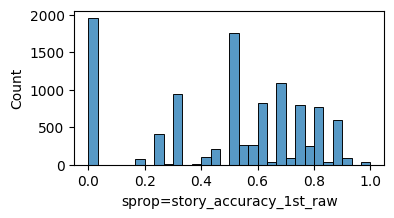

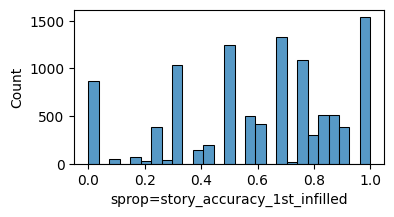

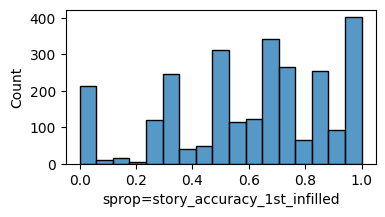

In [63]:
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(x=df['sprop=story_accuracy_1st_raw'], ax=ax)

_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(x=df['sprop=story_accuracy_1st_infilled'], ax=ax)

_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(x=dft['sprop=story_accuracy_1st_infilled'], ax=ax)

In [72]:
print('Train:', len(df.loc[df['sprop=story_accuracy_1st_infilled']<=0.8]), len(df))

print('Test:', len(dft.loc[dft['sprop=story_accuracy_1st_infilled']<=0.8]), len(dft))

Train: 7649 10647
Test: 1901 2662


In [134]:
df_train = df.loc[df['sprop=story_accuracy_1st_infilled']<=0.8].copy()
df_train.index = range(len(df_train))
df_train = df_train.rename(columns={'expected_answer':'answer'})

df_test = dft.loc[dft['sprop=story_accuracy_1st_infilled']<=0.8].copy()
df_test.index = range(len(df_test))
df_test = df_test.rename(columns={'expected_answer':'answer'})

In [135]:
df_train['prompt'][0][0]

{'content': "<|im_start|>system\nYou are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>. Now the user asks you to solve a theory of mind reasoning problem. After thinking, when you finally reach a conclusion, clearly state your answer within <answer> </answer> tags.\n<|im_end|>\n<|im_start|>user\nThe consulate meeting room was a quiet, formal space with a large wooden table and leather chairs, surrounded by walls lined with the flags of different countries. Soft morning light filtered in through the tall windows, casting a warm glow on the metal file cabinet in the corner. Peyton pushed open the door, and the soft creak of the hinge broke the silence as she stepped into the consulate meeting room. The silver letter o

In [ ]:
SYSTEM_PROMPT2 = """You are a helpful assistant.Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>"""

In [166]:
SYSTEM_PROMPT = """You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>."""

XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [167]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7649 entries, 0 to 7648
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   story_structure                          7649 non-null   object 
 1   infilled_story                           7649 non-null   object 
 2   question                                 7649 non-null   object 
 3   answer                                   7649 non-null   object 
 4   qprop=params                             7649 non-null   object 
 5   qprop=nth_order                          7649 non-null   int64  
 6   qprop=non_unique_mental_state            7649 non-null   bool   
 7   sprop=is_false_belief_story_1st          7649 non-null   bool   
 8   sprop=is_false_belief_story_1st_and_2nd  7649 non-null   bool   
 9   sprop=story_accuracy_1st_raw             7649 non-null   float64
 10  sprop=story_accuracy_1st_infilled        7649 no

In [168]:
def generate_prompt(x, i):
    data = { # type: ignore
            'prompt': [
                {'role': 'system', 'content': SYSTEM_PROMPT},
                {'role': 'user', 'content': XML_COT_FORMAT.format(x['infilled_story'], x['question'])}
            ],
            'answer': x['answer']
        }
    return data

In [169]:
data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

In [170]:
data = data.map(generate_prompt, with_indices=True)
test_data = test_data.map(generate_prompt, with_indices=True)

Map: 100%|██████████| 1901/1901 [00:00<00:00, 11575.73 examples/s]


In [171]:
len(data['prompt'])

7649

In [172]:
token_lengths = []
for prompt_list in data['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    content = str(prompt_list)
    # Tokenize the content
    tokens = tokenizer.encode(content)
    token_lengths.append(len(tokens))

<Axes: ylabel='Count'>

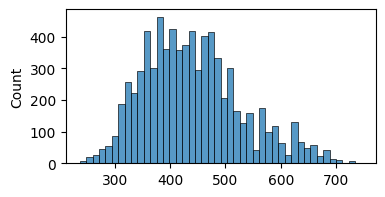

In [173]:
token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [174]:
len(token_lengths)

7649

In [175]:
np.median(token_lengths)

432.0

In [176]:
df_train_ = df_train.iloc[np.arange(len(token_lengths))[token_lengths<512]]
df_train_.index = range(len(df_train_))

In [177]:
data_train = Dataset.from_pandas(df_train_)
data_train = data_train.map(generate_prompt, with_indices=True)

Map: 100%|██████████| 6187/6187 [00:00<00:00, 9415.39 examples/s]


<Axes: ylabel='Count'>

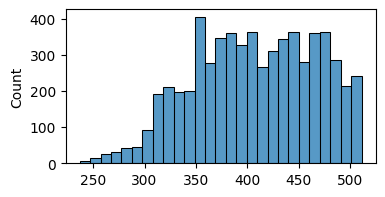

In [178]:
token_lengths2 = []
for prompt_list in data_train['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    content = str(prompt_list)
    # Tokenize the content
    tokens = tokenizer.encode(content)
    token_lengths2.append(len(tokens))
token_lengths2 = np.array(token_lengths2)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths2)

In [179]:
test_data.to_parquet('cleaned_test.parquet')
data_train.to_parquet('cleaned_train.parquet')

Creating parquet from Arrow format: 100%|██████████| 7/7 [00:00<00:00, 178.28ba/s]


30166123

In [180]:
test_data

Dataset({
    features: ['story_structure', 'infilled_story', 'question', 'answer', 'qprop=params', 'qprop=nth_order', 'qprop=non_unique_mental_state', 'sprop=is_false_belief_story_1st', 'sprop=is_false_belief_story_1st_and_2nd', 'sprop=story_accuracy_1st_raw', 'sprop=story_accuracy_1st_infilled', 'sprop=global_idx', 'param=story_type', 'param=num_stories_total', 'param=max_sentences', 'param=num_people', 'param=num_moves', 'param=num_rooms', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info'],
    num_rows: 1901
})

In [181]:
test_data['prompt'][0]

[{'content': 'You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>.',
  'role': 'system'},
 {'content': "Story: The operations center buzzed with fluorescent lighting, casting a sterile glow over the rows of metallic lockers, overflowing toolboxes, and a large plastic bin in the corner. Located in the heart of the amusement park, the center was surrounded by rickety roller coasters, worn pathways, and the distant sound of thrill-seekers. Charlotte's entry into the operations center momentarily disrupted the bustle of activity, her presence marked by the soft click of the door and her sharp eyes scanning the room. Charlotte secured the walkie-talkie inside the operations center's storage, gently closing the locker's